In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Setup

In [3]:
data = pd.read_msgpack("data_2018-11-06-22-59-57.msgpack")
df = pd.DataFrame.from_dict(data)
df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
if(df.iloc[0].timestamp > 0):
    df.timestamp -= df.iloc[0].timestamp
df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)
df.f = -df.f

Augment w/ minima, rolling mean

In [6]:
from scipy.signal import argrelmin, argrelmax, argrelextrema
minima = argrelmin(df.f.values, order=5000)[0]
maxima = argrelmax(df.f.values, order=5000)[0]
df['f_ra'] = df.f.rolling(window=300).mean()

In [12]:
df = df.fillna(0)

Mean, variance stationarity

In [21]:
df.f_ra.mean(), df.f_ra.var(), df.f_ra.min(), df.f_ra.max()

(21.684030983816214,
 103.2979611757999,
 -1.1003944220642248,
 40.441713879903155)

Detrend

In [35]:
df = df[df.f_ra > 5]

In [36]:
from scipy.signal import detrend
df['f_ra_det'] = detrend(df.f_ra, axis=-1, type='constant', bp=0)

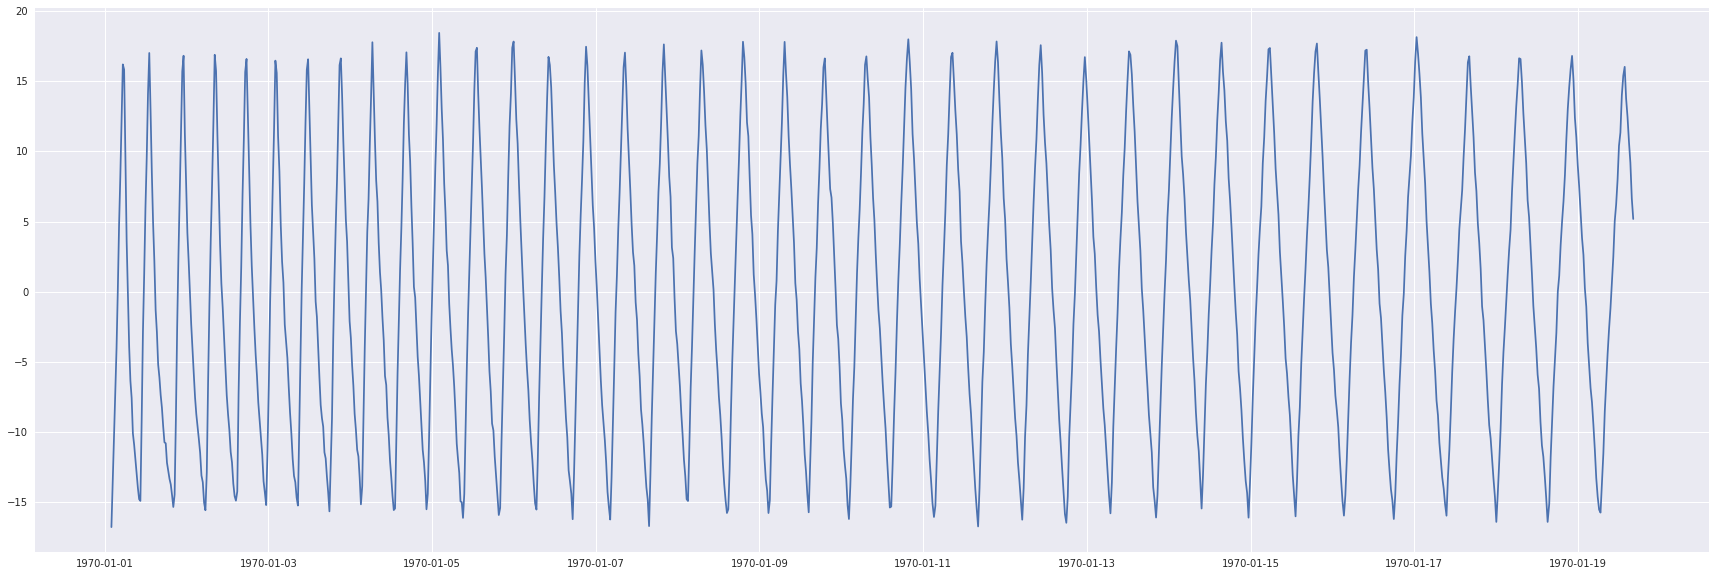

In [130]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10))
plt.plot(df.f_ra_det.iloc[::800])

These inform # of lags:

In [44]:
minima.shape, maxima.shape

((36,), (38,))

From now on `f_ra_det` is detrended rolling average force. AR terms come from high autocorrelation:

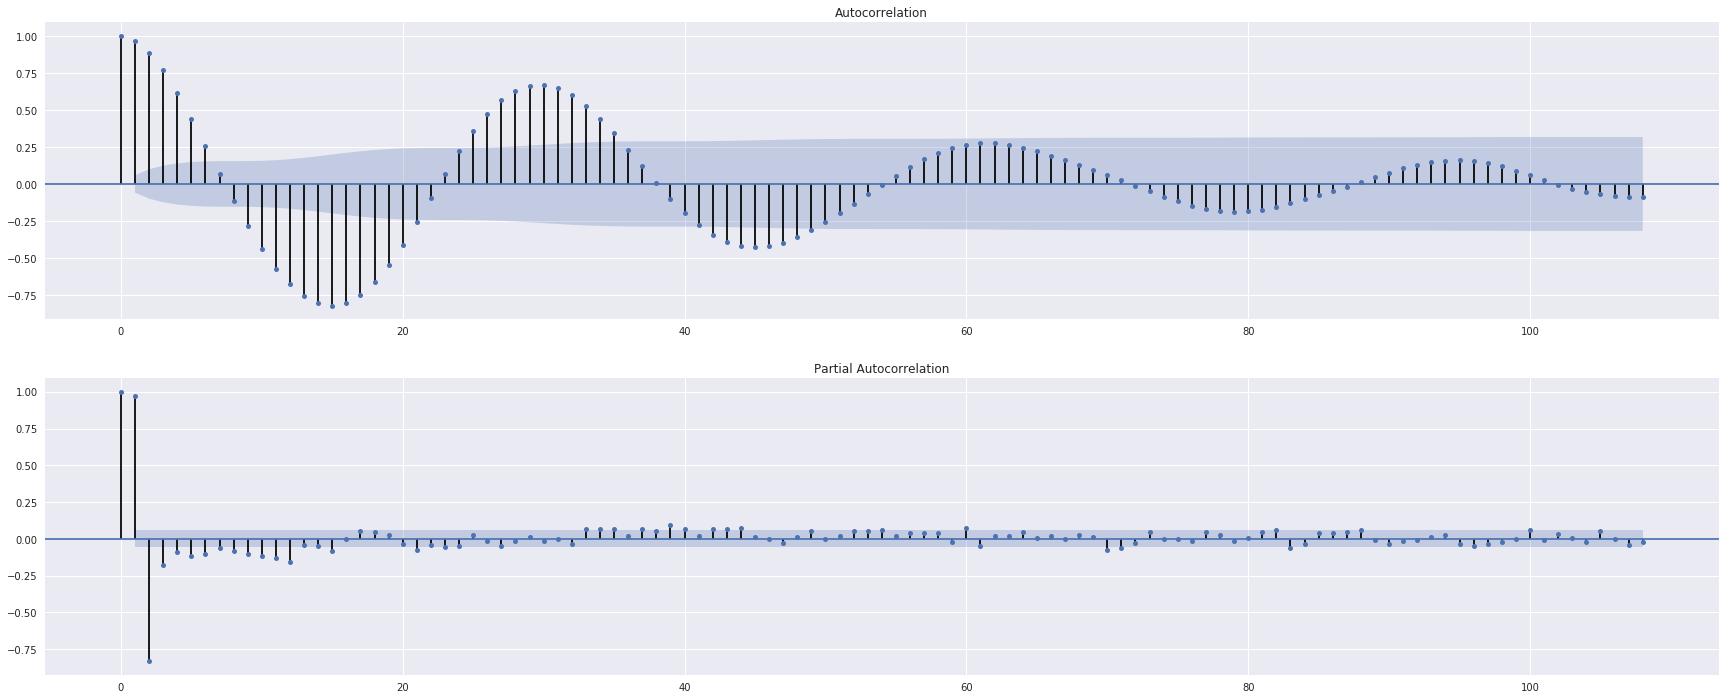

In [158]:
import statsmodels.api as sm
fig = plt.figure(figsize=(30,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.f_ra_det.iloc[::800], lags=108, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.f_ra_det[::800], lags=108, ax=ax2)
plt.show()

In [96]:
df['dt'] = df.timestamp * 100000
df.dt = pd.to_datetime(df.dt, unit='ms')
df = df.set_index('dt')

In [97]:
df.head()

,f,mdia,msgtype,pwm,rc,rw,t,t0,timestamp,f_ra,f_ra_det
dt,,,,,,,,,,,
1970-01-01 02:00:23.610877991,5.464552,1.0,2,150.0,27.5,0.35,34.183258,24.727188,72.236109,5.005800,-16.782868
1970-01-01 02:00:24.607276917,4.343770,1.0,2,150.0,27.5,0.35,34.183258,24.727188,72.246073,5.006797,-16.781871
1970-01-01 02:00:26.510810852,6.094062,1.0,2,150.0,27.5,0.35,34.189365,24.727188,72.265108,5.016541,-16.772127
1970-01-01 02:00:28.495216370,5.250987,1.0,2,150.0,27.5,0.35,34.189365,24.727188,72.284952,5.017539,-16.771130
1970-01-01 02:00:30.391883850,6.265777,1.0,2,150.0,27.5,0.35,34.193535,24.728174,72.303919,5.021741,-16.766927


In [98]:
from statsmodels.tsa.arima_model import ARIMA as ARIMA

In [174]:
model = ARIMA(endog=df.f_ra_det.iloc[::800], order=(15,1,1))
results = model.fit()

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


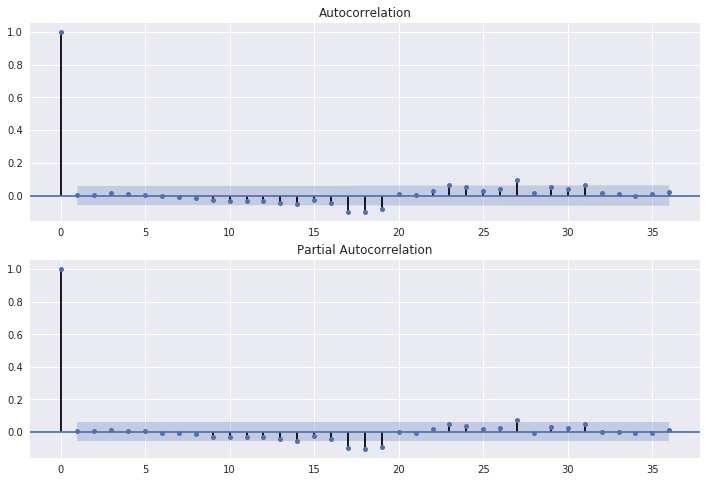

In [175]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=36, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=36, ax=ax2)
plt.show()

In [125]:
results.summary()

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D2.f_ra_det   No. Observations:                 1115
Model:                 ARIMA(0, 2, 3)   Log Likelihood               -1914.016
Method:                       css-mle   S.D. of innovations              1.347
Date:                Thu, 08 Nov 2018   AIC                           3838.032
Time:                        16:39:41   BIC                           3863.115
Sample:                    01-01-1970   HQIC                          3847.515
                         - 01-19-1970                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0042      0.041     -0.103      0.918      -0.084       0.076
ma.L1.D2.f_ra_det     0.0363      0.030      1.210      0.227      -0.022       0.095
ma.L2.D2.f_ra_det     0.0113      0.031      0.366      0.714      -0.049       0.072
ma.L3.D2.f_ra_det    -0.0376      0.031     -1.209      0.227      -0.098       0.023
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4497           -2.4928j            2.8837           -0.3338
MA.2           -1.4497           +2.4928j            2.8837            0.3338
MA.3            3.2011           -0.0000j            3.2011           -0.0000
-----------------------------------------------------------------------------
"""

In [176]:
r = results.predict(start = 2, end = df.f_ra_det.iloc[::800].size-1) #, dynamic= True)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [177]:
rms = np.sqrt(np.mean(np.abs((df.f_ra_det.iloc[::800]-r**2))))

In [178]:
rms

3.1520407288776418

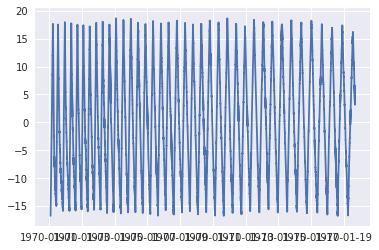

In [179]:
plt.plot(df.f_ra_det.iloc[::800])

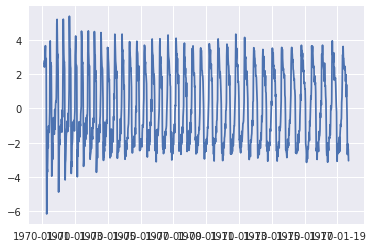

In [180]:
plt.plot(r)

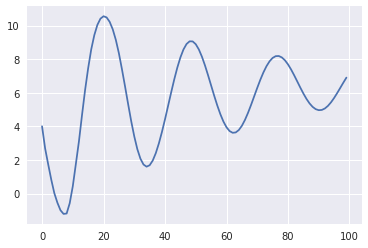

In [173]:
forecast, std, conf = results.forecast(100)
plt.plot(forecast)

# GARBAGE BELOW

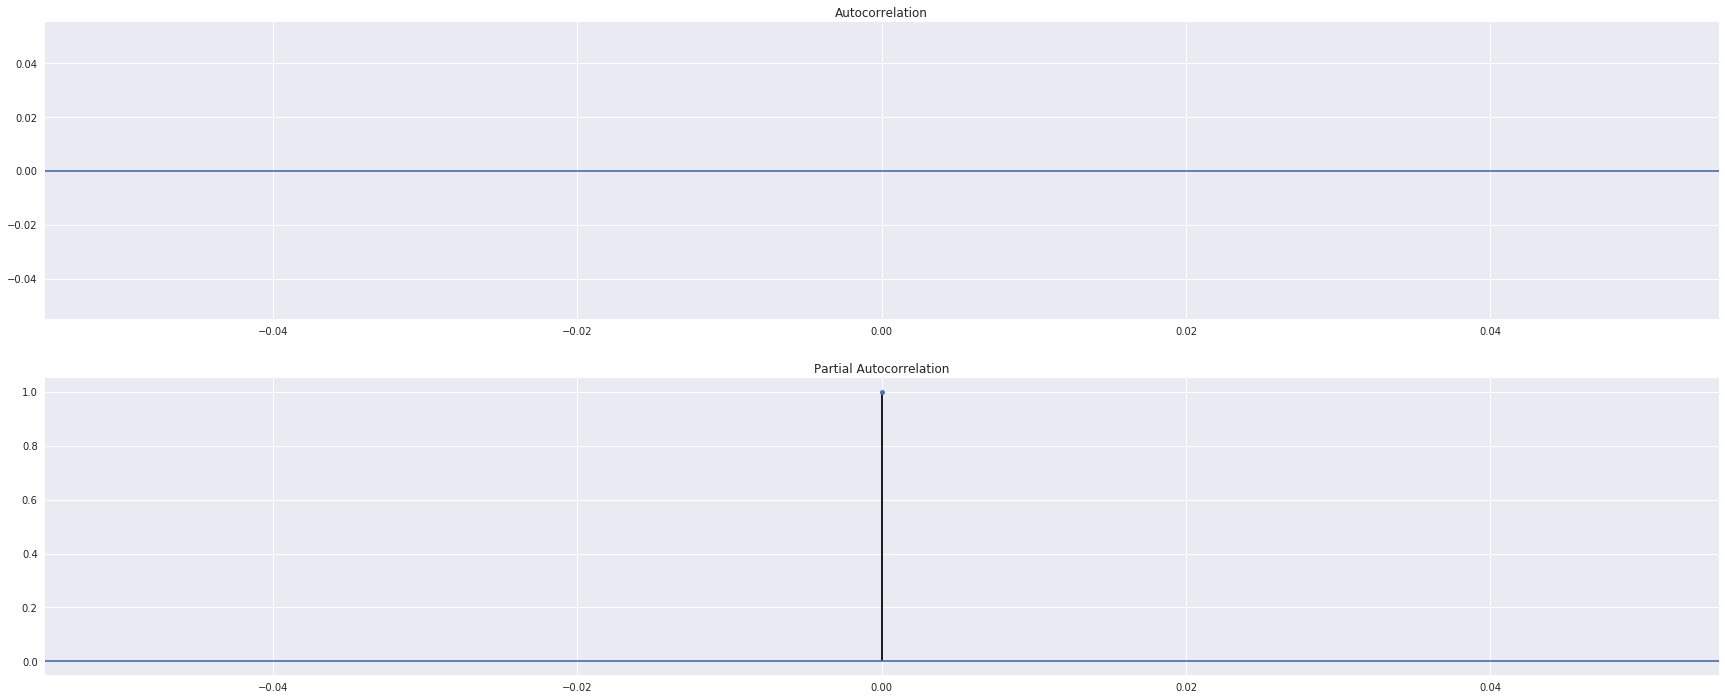

In [41]:
fig = plt.figure(figsize=(30,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.f.iloc[::10].diff(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.f.iloc[::10].diff(), lags=40, ax=ax2)
plt.show()

In [9]:
# t: point in time
# tc: time constant
# a: amplitude
def LOOSE(t, t0, tc, a, p0, is_heating):
    k = 1 if is_heating else -1
    return p0 * (1 + a*(np.exp(k*(t-t0)/(tc)))) # * np.exp(t/tc)

In [10]:
a = df.f.max()
t0 = 0
p0 = 1
tc = 8000
is_heating = True

In [11]:
loosies = df.timestamp.apply(LOOSE, args=(t0, 2000, a, p0, is_heating))

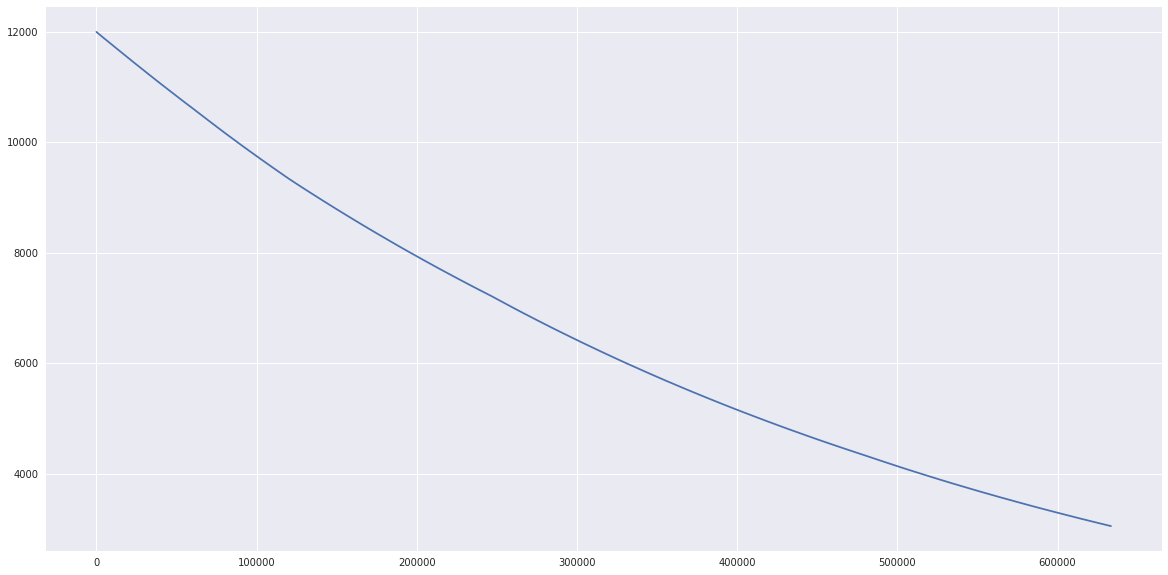

In [12]:
loosies = df.timestamp.apply(LOOSE, args=(t0, tc, 12000, p0, not is_heating))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plt.plot(loosies)

In [13]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [14]:
ma = df.f.rolling(window=300).mean().dropna()
tsma = df.timestamp.rolling(window=300).mean().dropna()
X = pd.DataFrame({'ma': ma, 'tsma': tsma}) #df.timestamp.values.reshape(df.timestamp.size//2, 2)
y = ma

In [15]:
X.head()

,ma,tsma
299,0.628544,2.456122
300,0.624040,2.472461
301,0.622513,2.488817
302,0.617728,2.505203
303,0.611173,2.521591


In [28]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X) #x1^0x2^0, ^1^0, ^0^1, ^2^0, ^1^1, ^0^2

array([[1.00000000e+00, 6.28543919e-01, 2.45612203e+00, 3.95067458e-01,
        1.54378057e+00, 6.03253542e+00],
       [1.00000000e+00, 6.24040213e-01, 2.47246071e+00, 3.89426188e-01,
        1.54291491e+00, 6.11306196e+00],
       [1.00000000e+00, 6.22513496e-01, 2.48881742e+00, 3.87523053e-01,
        1.54932243e+00, 6.19421214e+00],
       ...,
       [1.00000000e+00, 1.01081709e+00, 1.09392940e+04, 1.02175120e+00,
        1.10576253e+04, 1.19668153e+08],
       [1.00000000e+00, 1.00851773e+00, 1.09393123e+04, 1.01710802e+00,
        1.10324904e+04, 1.19668553e+08],
       [1.00000000e+00, 1.00561858e+00, 1.09393306e+04, 1.01126872e+00,
        1.10007941e+04, 1.19668954e+08]])

In [29]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression(fit_intercept=False))])

In [30]:
model = model.fit(X, y)

In [31]:
model.named_steps['linear'].coef_, model.named_steps['linear'].intercept_

(array([ 5.61427682e-09,  1.00000000e+00, -4.04517457e-14,  1.34544678e-14,
         5.55978874e-16,  0.00000000e+00]), 0.0)

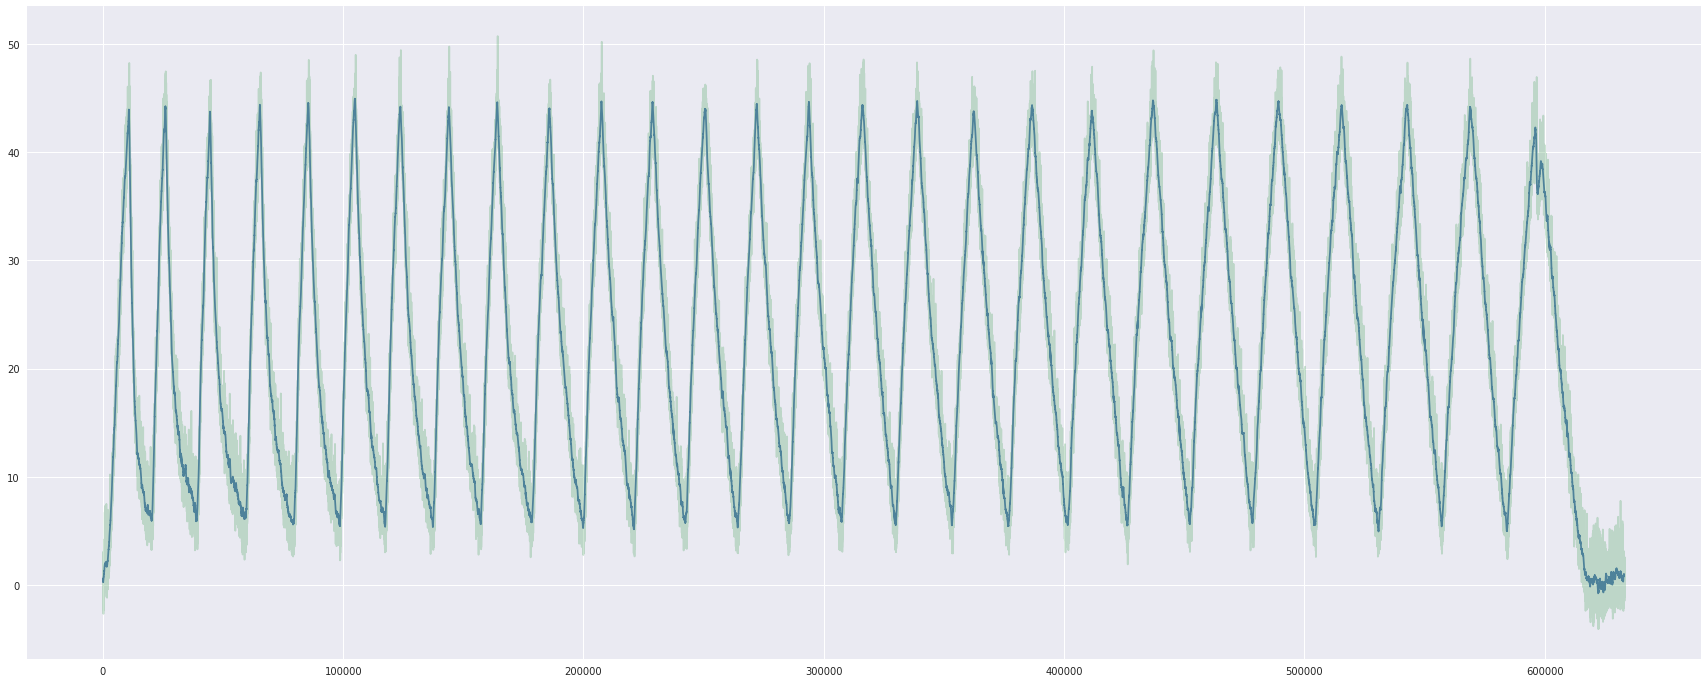

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,12))
ax.plot(model.predict(X))
ax.plot(df.f, alpha=.3)

In [48]:
def EZ_MODEL(x):
    xp = x.values
    coefs = [ 5.61427682e-09,  1.00000000e+00, -4.04517457e-14,  1.34544678e-14, 5.55978874e-16 ]
    #coefs = [1, 1, 1, 1, 1]
    yhat = coefs[0]*xp[:,0] + coefs[1]*xp[:,1] + coefs[2]*(xp[:,0]**2) + coefs[3]*(xp[:,0]*xp[:,1]) + coefs[4]*(xp[:,1]**2) #x1^0x2^0, ^1^0, ^0^1, ^2^0, ^1^1, ^0^2 
    return yhat

In [49]:
yhat = EZ_MODEL(X)

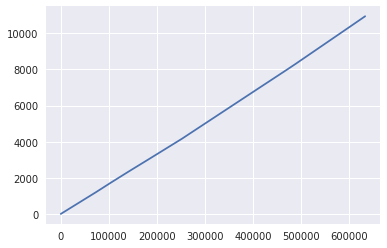

In [50]:
plt.plot(yhat)

### single cycle

/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


In [99]:
minima, maxima

(array([   214,  20174,  38313,  79155,  98694, 117433, 136368, 156336,
        178013, 199924, 221258, 241686, 264319, 285324, 307736, 330042,
        377151, 400604, 426503, 452401, 477609, 504812, 530607, 557268,
        584535, 622356]),
 array([ 10975,  26153,  45021,  65632,  85677, 105194, 123991, 144138,
        164291, 186173, 207596, 228875, 250710, 272266, 294110, 316578,
        338806, 361751, 387943, 411694, 437241, 463216, 490004, 515464,
        542936, 569062, 596704, 631609]))

## rising front

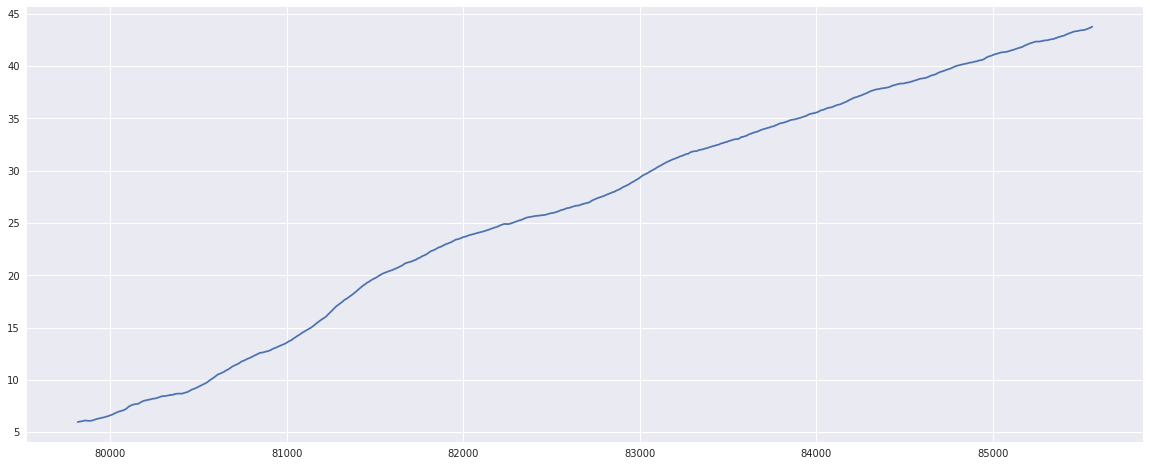

In [115]:
plt.figure(figsize=(20,8))
plt.plot(X.f)

In [121]:
print(np.where(~np.isfinite(X.f.values)))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [122]:
np.polyfit(X.timestamp.values[299:], X.f.values[299:], 1)

array([ 4.04202640e-01, -5.25391322e+02])

In [125]:
from scipy.optimize import curve_fit

In [154]:
curve_fit(lambda t,a,b: a*np.exp(b*t),  X.timestamp.values[299:]-X.timestamp.values[299],  X.f.values[299:], p0=(1, 0.1))

(array([12.18783049,  0.01428122]), array([[ 2.99690222e-03, -3.19125356e-06],
        [-3.19125356e-06,  3.79438365e-09]]))

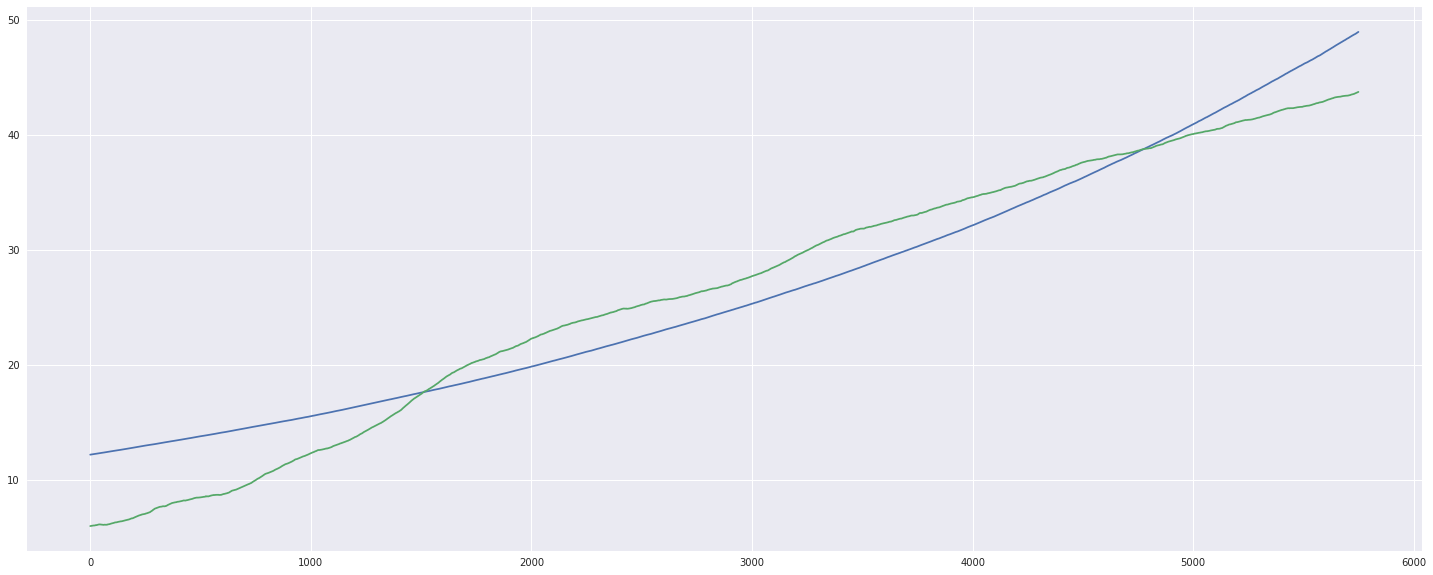

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
ax.plot(12.18781192*np.exp(0.01428125*(X.timestamp.values[299:]-X.timestamp.values[299])))
ax.plot(X.f.values[299:])

## falling front

In [167]:
maxima[4], minima[4]

(85677, 98694)

In [174]:
X = df.iloc[maxima[4]:minima[4],]
X.f = X.f.rolling(window=300).mean()

/home/nwchen/.local/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


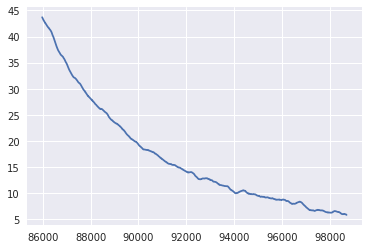

In [175]:
plt.plot(X.f)

In [1]:
curve_fit(lambda t,a,b: a*np.exp(b*t),  X.timestamp.values[299:]-X.timestamp.values[299],  X.f.values[299:], p0=(1, 0.1))

NameError: name 'curve_fit' is not defined

$$ \hat{F}(t)_{A} = Ae^{\frac{t-t_0}{\tau}} = 4.09e^{-0.00993t} $$

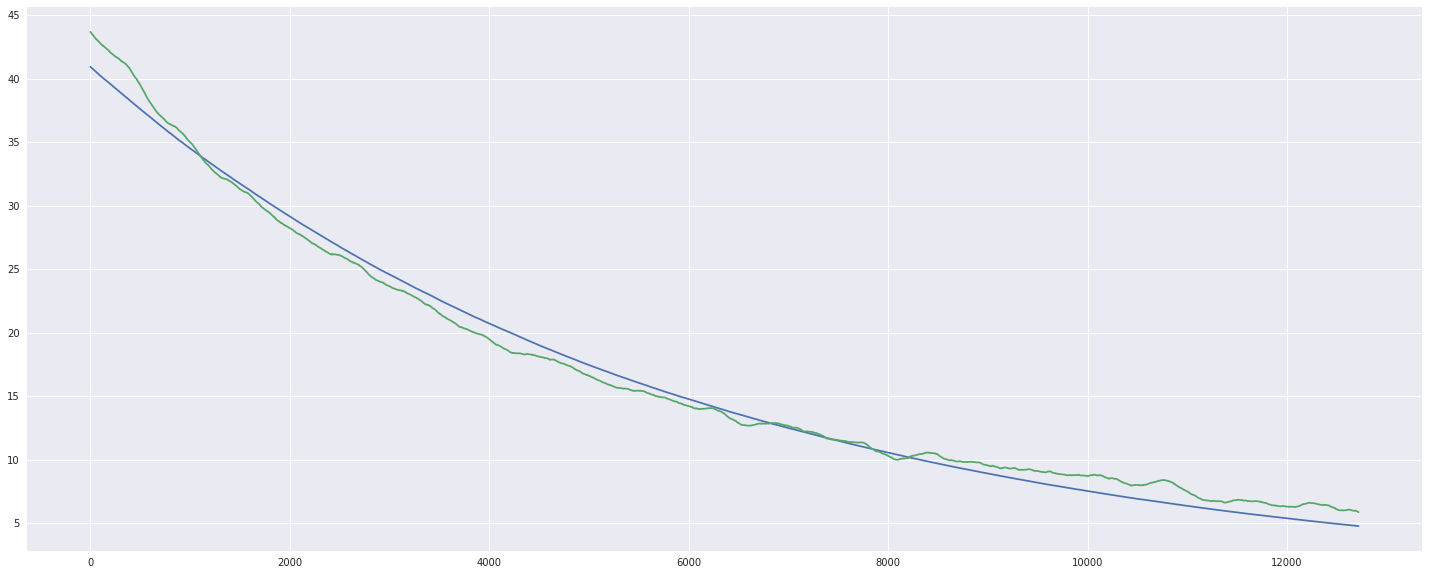

In [178]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
ax.plot(4.09413046e+01*np.exp(-9.93004214e-03*(X.timestamp.values[299:]-X.timestamp.values[299])))
ax.plot(X.f.values[299:])

### deriving `tc` from period trend (`a` update)

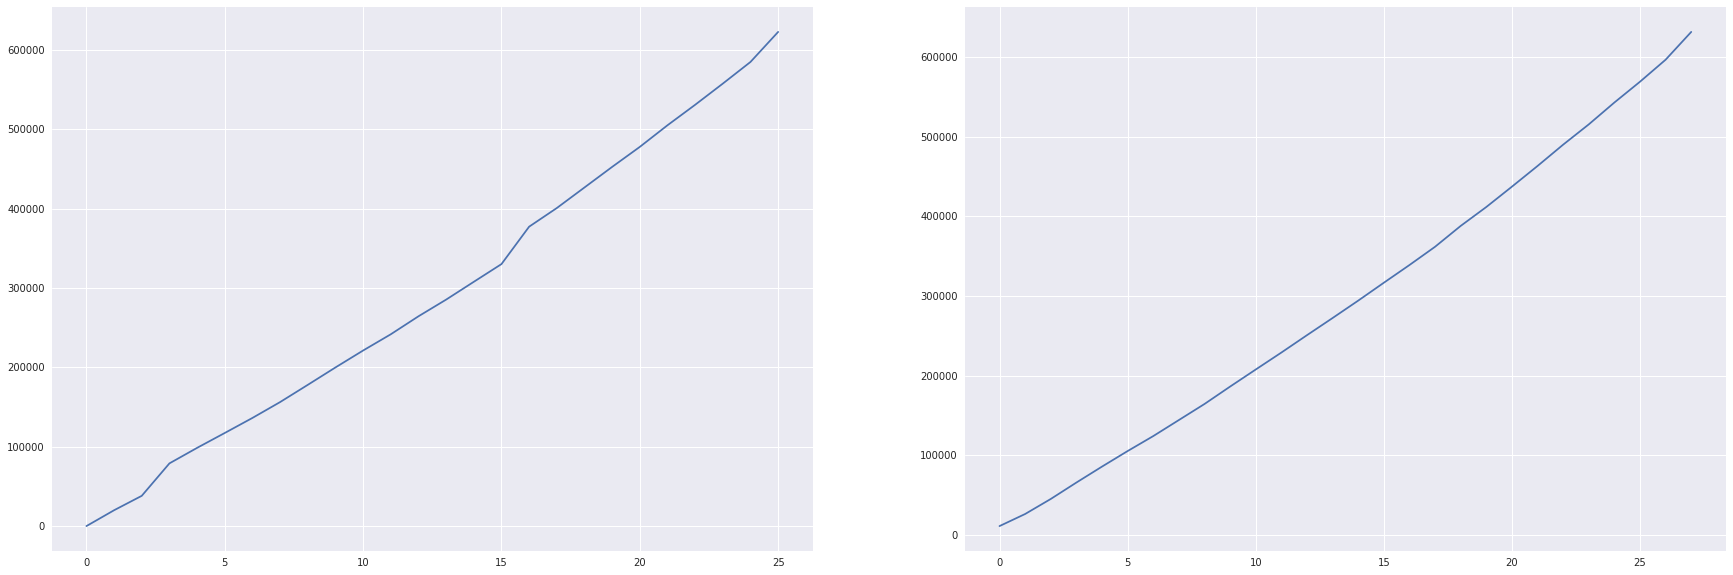

In [183]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
ax.flat[0].plot(minima)
ax.flat[1].plot(maxima)

In [191]:
def PERIODS(extrema, data):
    p = np.empty(extrema.shape)
    for i in range(1, extrema.shape[0]):
        p[i] = data[extrema[i]] - data[extrema[i-1]]
    return p

In [194]:
pmin = PERIODS(minima, df.timestamp.values)
pmax = PERIODS(maxima, df.timestamp.values)

In [212]:
rangemin = np.arange(pmin.shape[0]).reshape(-1, 1)
rangemax = np.arange(pmax.shape[0]).reshape(-1, 1)

In [235]:
from sklearn.linear_model import Ridge

In [240]:
regmin = Ridge(alpha=10).fit(rangemin, pmin)
regmax = Ridge(alpha=10).fit(rangemax[3:-2], pmax[3:-2])

$$ \Delta \textrm{period} = \vert t^i_{min} - t^{i-1}_{min} \vert $$ over time

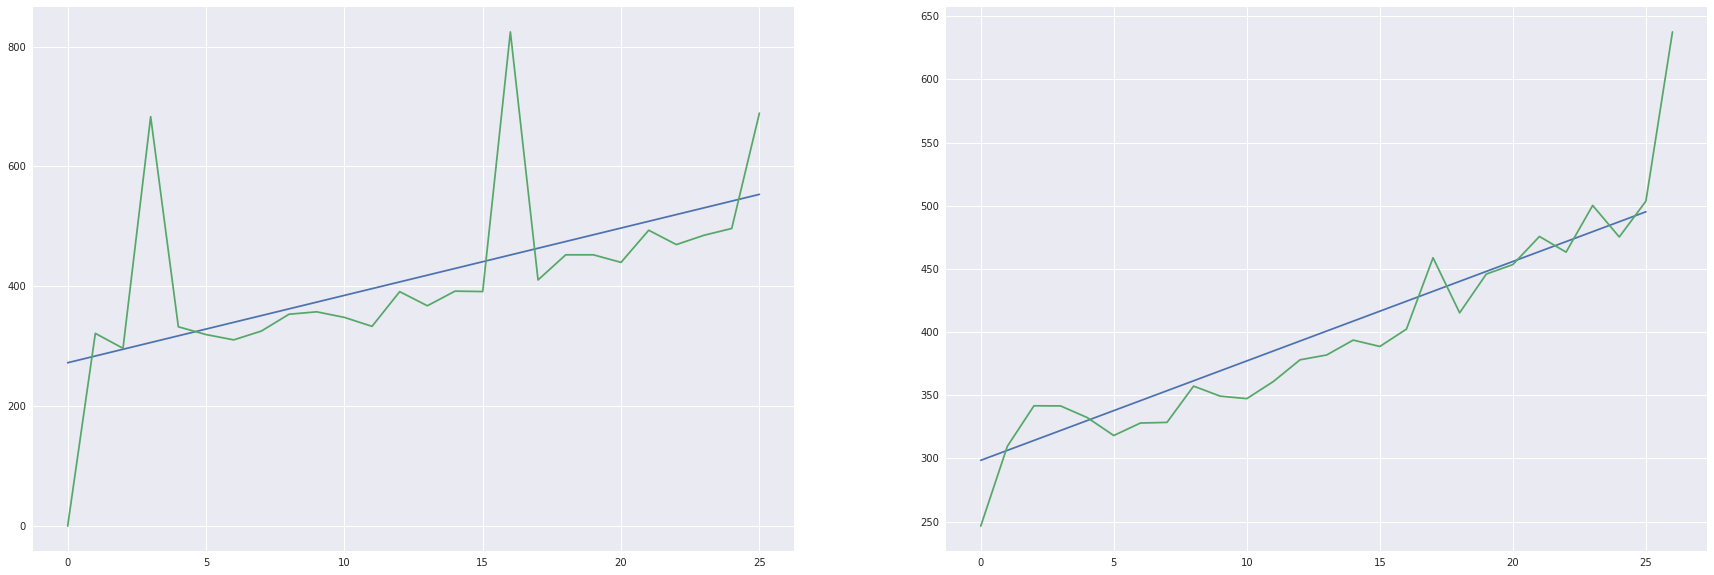

In [241]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
ax.flat[0].plot(regmin.predict(rangemin))
ax.flat[0].plot(pmin)
ax.flat[1].plot(regmax.predict(rangemax[2:]))
ax.flat[1].plot(pmax[1:])[0]

In [244]:
def regmin.coef_, regmin.intercept_, regmax.coef_, regmax.intercept_

(array([11.23701196]), 272.51819267038803, array([7.8670855]), 282.77006235401)

In [246]:
def SRM(t0, t, pwm):
    if pwm==0:
        return 4.09413046e+01*np.exp(-9.93004214e-03*(t-t0))
    if pwm==1:
        return 12.18781192*np.exp(0.01428125*(t-t0))
    return -1

In [250]:
df.pwm.fillna(value=0.0, inplace=True)

In [252]:
df

,f,mdia,msgtype,pwm,rc,rw,t,t0,timestamp
0,1.924732,1.0,2,0.0,29.1,0.4,29.597118,26.686825,0.000000
1,1.903733,1.0,2,0.0,29.1,0.4,29.597118,26.686825,0.013638
2,1.318297,1.0,2,0.0,29.1,0.4,29.596083,26.689442,0.023941
3,0.999092,1.0,2,0.0,29.1,0.4,29.596083,26.689442,0.042946
4,2.489463,1.0,2,0.0,29.1,0.4,29.599459,26.689442,0.062157
5,0.499448,1.0,2,0.0,29.1,0.4,29.599459,26.689442,0.081833
6,0.733154,1.0,2,0.0,29.1,0.4,29.596083,26.689442,0.100975
7,3.075488,1.0,2,0.0,29.1,0.4,29.596083,26.689442,0.120380
8,1.956969,1.0,2,0.0,29.1,0.4,29.597118,26.686825,0.139790
9,1.211885,1.0,2,0.0,29.1,0.4,29.597118,26.686825,0.149719


In [251]:
SRM(0, df.timestamp.values, df.pwm)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().